## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=reduce_factor,
                                  patience=reduce_patient,
                                  verbose=1,
                                  min_lr=1e-12,)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - ETA: 0s - loss: 2.2645 - accuracy: 0.2627WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E3C01A9C18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - 4s 90ms/step - loss: 2.2519 - accuracy: 0.2580 - val_loss: 2.1716 - val_accuracy: 0.1954
Epoch 2/25
49/49 [==============================] - 4s 77ms/step - loss: 1.7750 - accuracy: 0.3811 - val_loss: 1.9992 - val_accuracy: 0.2973
Epoch 3/25
49/49 [==============================] - 4s 77ms/step - loss: 1.6395 - accuracy: 0.4264 - val_loss: 1.8279 - val_accuracy: 0.3688
Epoch 4/25
49/49 [==============================] - 4s 76ms/step - loss: 1.5655 - accuracy: 0.4506 - val_loss: 1.7055 - val_accuracy: 0.4083
Epoch 5/25
49/49 [==============================] - 4s 86ms/step - loss: 1.5096 - accuracy: 0.4705 - val_loss: 1.6181 - val_accuracy: 0.

49/49 [==============================] - 3s 70ms/step - loss: 1.4583 - accuracy: 0.4895 - val_loss: 1.5803 - val_accuracy: 0.4454
Epoch 7/25
49/49 [==============================] - 3s 68ms/step - loss: 1.4213 - accuracy: 0.5029 - val_loss: 1.5414 - val_accuracy: 0.4536
Epoch 8/25
49/49 [==============================] - 4s 73ms/step - loss: 1.3913 - accuracy: 0.5138 - val_loss: 1.5213 - val_accuracy: 0.4655
Epoch 9/25
49/49 [==============================] - 5s 93ms/step - loss: 1.3617 - accuracy: 0.5247 - val_loss: 1.4935 - val_accuracy: 0.4757
Epoch 10/25
49/49 [==============================] - 5s 92ms/step - loss: 1.3339 - accuracy: 0.5353 - val_loss: 1.4902 - val_accuracy: 0.4795
Epoch 11/25
49/49 [==============================] - 4s 86ms/step - loss: 1.3090 - accuracy: 0.5460 - val_loss: 1.4790 - val_accuracy: 0.4810
Epoch 12/25
49/49 [==============================] - 3s 70ms/step - loss: 1.2859 - accuracy: 0.5510 - val_loss: 1.4696 - val_accuracy: 0.4832
Epoch 13/25
49/49 [==

Epoch 14/25
49/49 [==============================] - 3s 68ms/step - loss: 0.7515 - accuracy: 0.7449 - val_loss: 1.6382 - val_accuracy: 0.4723
Epoch 15/25
48/49 [============================>.] - ETA: 0s - loss: 0.7177 - accuracy: 0.7572
Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
49/49 [==============================] - 3s 67ms/step - loss: 0.7181 - accuracy: 0.7567 - val_loss: 1.6224 - val_accuracy: 0.4769
Epoch 16/25
49/49 [==============================] - 3s 66ms/step - loss: 0.6381 - accuracy: 0.7937 - val_loss: 1.4281 - val_accuracy: 0.5194
Epoch 17/25
49/49 [==============================] - 3s 65ms/step - loss: 0.6031 - accuracy: 0.8091 - val_loss: 1.5225 - val_accuracy: 0.5060
Epoch 18/25
49/49 [==============================] - 3s 67ms/step - loss: 0.5804 - accuracy: 0.8167 - val_loss: 1.5190 - val_accuracy: 0.5019
Epoch 19/25
49/49 [==============================] - 3s 65ms/step - loss: 0.5589 - accuracy: 0.8252 - val_loss: 1.5185 - val_ac

49/49 [==============================] - 3s 64ms/step - loss: 0.9868 - accuracy: 0.6669 - val_loss: 1.4277 - val_accuracy: 0.5046
Epoch 20/25
49/49 [==============================] - 3s 65ms/step - loss: 0.9676 - accuracy: 0.6743 - val_loss: 1.4243 - val_accuracy: 0.5070
Epoch 21/25
49/49 [==============================] - 3s 64ms/step - loss: 0.9508 - accuracy: 0.6813 - val_loss: 1.4412 - val_accuracy: 0.5025
Epoch 22/25
49/49 [==============================] - 3s 71ms/step - loss: 0.9345 - accuracy: 0.6882 - val_loss: 1.4381 - val_accuracy: 0.5040
Epoch 23/25
49/49 [==============================] - 4s 82ms/step - loss: 0.9201 - accuracy: 0.6922 - val_loss: 1.4482 - val_accuracy: 0.4975
Epoch 24/25
49/49 [==============================] - 4s 76ms/step - loss: 0.9029 - accuracy: 0.7009 - val_loss: 1.4552 - val_accuracy: 0.5000
Epoch 25/25
49/49 [==============================] - 4s 81ms/step - loss: 0.8862 - accuracy: 0.7083 - val_loss: 1.4598 - val_accuracy: 0.5032
Numbers of exp: 6,

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/49 [============================>.] - ETA: 0s - loss: 2.3890 - accuracy: 0.2250WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001E3BFB928B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - 5s 95ms/step - loss: 1.8423 - accuracy: 0.3646 - val_loss: 2.5332 - val_accuracy: 0.1693
Epoch 2/25
49/49 [==============================] - 4s 81ms/step - loss: 1.5425 - accuracy: 0.4543 - val_loss: 2.0274 - val_accuracy: 0.2804
Epoch 3/25
49/49 [==============================] - 5s 95ms/step - loss: 1.4297 - accuracy: 0.4917 - val_loss: 2.0207 - val_accuracy: 0.2912
Epoch 4/25
49/49 [==============================] - 5s 92ms/step - loss: 1.3456 - accuracy: 0.5239 - val_loss: 1.8622 - val_accuracy: 0.3532
Epoch 5/25
49/49 [==============================] - 4s 89ms/step - loss: 1.2817 - accuracy: 0.5460 - val_loss: 2.3188 - val_accuracy: 0.

49/49 [==============================] - 5s 106ms/step - loss: 1.3612 - accuracy: 0.5256 - val_loss: 1.7605 - val_accuracy: 0.3846
Epoch 5/25
49/49 [==============================] - 5s 101ms/step - loss: 1.2960 - accuracy: 0.5480 - val_loss: 1.8567 - val_accuracy: 0.3643
Epoch 6/25
49/49 [==============================] - 5s 102ms/step - loss: 1.2427 - accuracy: 0.5672 - val_loss: 1.6145 - val_accuracy: 0.4148
Epoch 7/25
49/49 [==============================] - 4s 90ms/step - loss: 1.1912 - accuracy: 0.5853 - val_loss: 1.6023 - val_accuracy: 0.4393
Epoch 8/25
49/49 [==============================] - 4s 87ms/step - loss: 1.1508 - accuracy: 0.6022 - val_loss: 1.7571 - val_accuracy: 0.3934
Epoch 9/25
49/49 [==============================] - 4s 91ms/step - loss: 1.1090 - accuracy: 0.6158 - val_loss: 1.7431 - val_accuracy: 0.4214
Epoch 10/25
49/49 [==============================] - 4s 84ms/step - loss: 1.0718 - accuracy: 0.6319 - val_loss: 2.0900 - val_accuracy: 0.3571
Epoch 11/25
49/49 [=

49/49 [==============================] - 4s 81ms/step - loss: 0.9960 - accuracy: 0.6576 - val_loss: 1.7039 - val_accuracy: 0.4259
Epoch 13/25
49/49 [==============================] - 4s 82ms/step - loss: 0.9671 - accuracy: 0.6703 - val_loss: 1.5103 - val_accuracy: 0.4745
Epoch 14/25
49/49 [==============================] - 4s 79ms/step - loss: 0.9365 - accuracy: 0.6802 - val_loss: 1.9359 - val_accuracy: 0.3835
Epoch 15/25
49/49 [==============================] - 4s 80ms/step - loss: 0.9076 - accuracy: 0.6908 - val_loss: 1.7824 - val_accuracy: 0.4334
Epoch 16/25
49/49 [==============================] - 4s 81ms/step - loss: 0.8806 - accuracy: 0.7002 - val_loss: 1.7546 - val_accuracy: 0.4113
Epoch 17/25
49/49 [==============================] - 4s 90ms/step - loss: 0.8549 - accuracy: 0.7112 - val_loss: 1.7783 - val_accuracy: 0.4352
Epoch 18/25
49/49 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.7246
Epoch 00018: ReduceLROnPlateau reducing learning rate to 2.500000

49/49 [==============================] - 4s 82ms/step - loss: 1.9638 - accuracy: 0.3341 - val_loss: 1.9876 - val_accuracy: 0.3305
Epoch 19/25
49/49 [==============================] - 4s 79ms/step - loss: 1.9463 - accuracy: 0.3379 - val_loss: 1.9720 - val_accuracy: 0.3346
Epoch 20/25
49/49 [==============================] - 4s 83ms/step - loss: 1.9300 - accuracy: 0.3420 - val_loss: 1.9585 - val_accuracy: 0.3364
Epoch 21/25
49/49 [==============================] - 4s 82ms/step - loss: 1.9152 - accuracy: 0.3474 - val_loss: 1.9467 - val_accuracy: 0.3405
Epoch 22/25
49/49 [==============================] - 4s 83ms/step - loss: 1.8998 - accuracy: 0.3521 - val_loss: 1.9353 - val_accuracy: 0.3447
Epoch 23/25
49/49 [==============================] - 4s 88ms/step - loss: 1.8877 - accuracy: 0.3549 - val_loss: 1.9240 - val_accuracy: 0.3457
Epoch 24/25
49/49 [==============================] - 4s 91ms/step - loss: 1.8747 - accuracy: 0.3582 - val_loss: 1.9119 - val_accuracy: 0.3496
Epoch 25/25
49/49 

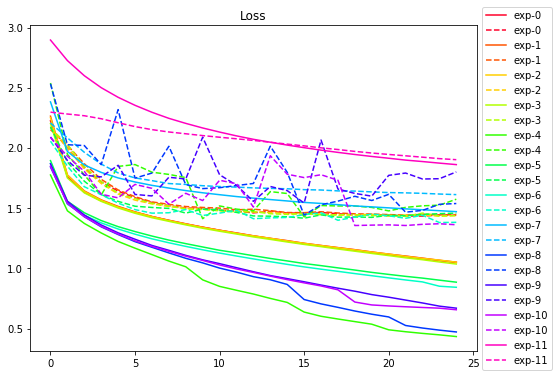

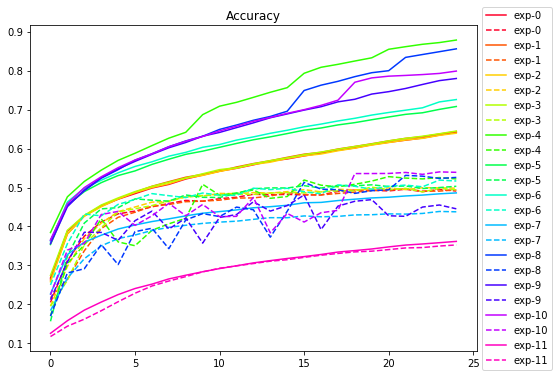

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()